In [2]:
from pathlib import Path
import pandas as pd
import os
import numpy as np
from matplotlib import pyplot as plt
from spectroscopy.fies_utils import normalize_continuum_slice, slice_spectrum_data
from sklearn.preprocessing import minmax_scale
from spectroscopy.fies_utils import _rotational_profile, estimate_vsini

_SPECTRA_FILE =  os.path.normpath(r"data\out\2_vrad_corrected_spectra.npz")
_STAR_DATA = Path.cwd() / "data" / "star_data.csv"
_SPECTRUM_SLICE_OFFSET = 100
_ABSORPTION_LINE_WIDTH = 3
_ABSORPTION_LINE = 6024.0568

h_width = _ABSORPTION_LINE_WIDTH/2
vrad_corrected_spectra = np.load(_SPECTRA_FILE)
_star_data = pd.read_csv(_STAR_DATA, index_col="name")

## Spectrum normalization around line

S:\Projects\git\astro_obs_2023\spectroscopy\fies_utils.py:62: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, deg=degree)
S:\Projects\git\astro_obs_2023\spectroscopy\fies_utils.py:62: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, deg=degree)


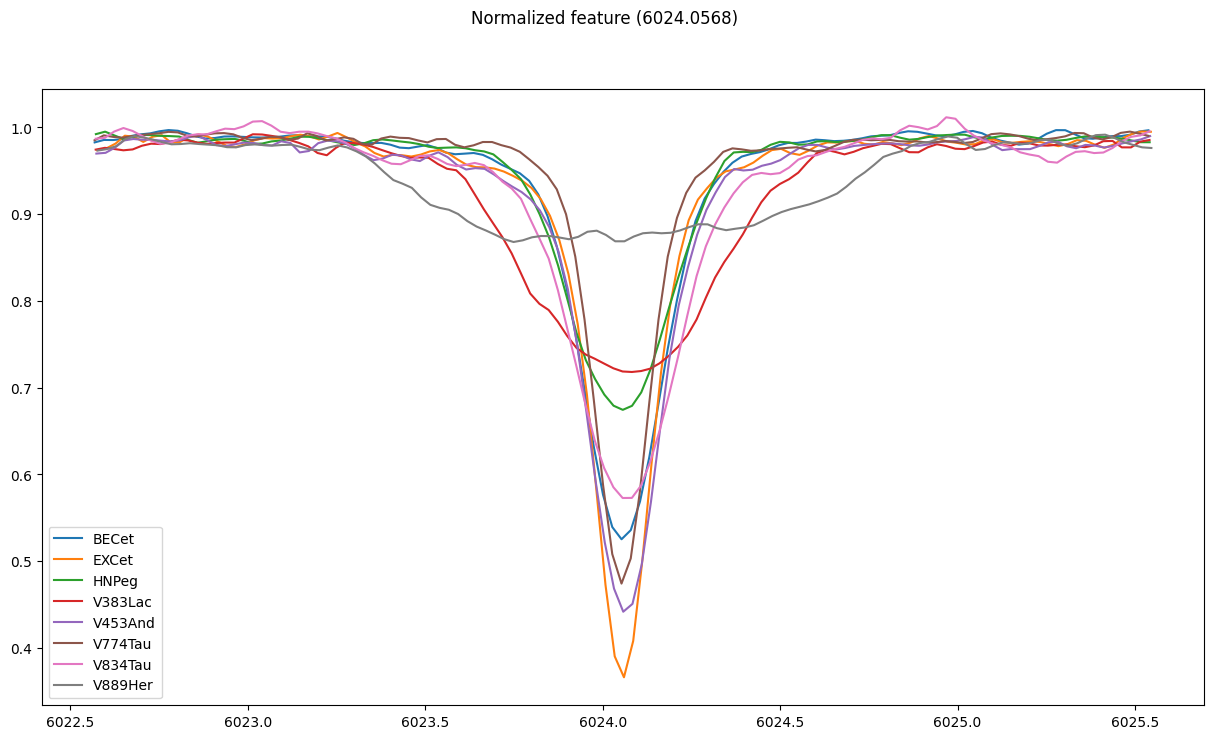

In [3]:
features = {}
default = {"degree": 4, "iterations": 8}
normalization_settings = {
    "V834Tau": {"degree": 3, "iterations": 3},
    "V383Lac": {"degree": 5, "iterations": 8}
}

plt.figure(figsize=(15, 8))
for target, data in vrad_corrected_spectra.items():
    normalized_data, _ = normalize_continuum_slice(
        data=data, 
        w_min=_ABSORPTION_LINE-_SPECTRUM_SLICE_OFFSET, 
        w_max=_ABSORPTION_LINE+_SPECTRUM_SLICE_OFFSET,
        **normalization_settings.get(target, default))
    
    feature_slice = slice_spectrum_data(normalized_data, w_min=_ABSORPTION_LINE - h_width, w_max=_ABSORPTION_LINE+h_width)
    features[target] = feature_slice
    plt.plot(feature_slice[:, 0], feature_slice[:, 1], label=target)

plt.suptitle(f"Normalized feature ({_ABSORPTION_LINE})")
plt.legend()
plt.show()

## Plot feature lines

BECet vsini: 9.381507306420282
EXCet vsini: 7.25001802495672
HNPeg vsini: 11.125592903035916
V383Lac vsini: 21.143920956677892
V453And vsini: 8.171488952919626
V774Tau vsini: 6.43428535218582
V834Tau vsini: 12.094672091845426
V889Her vsini: 39.48848912561446


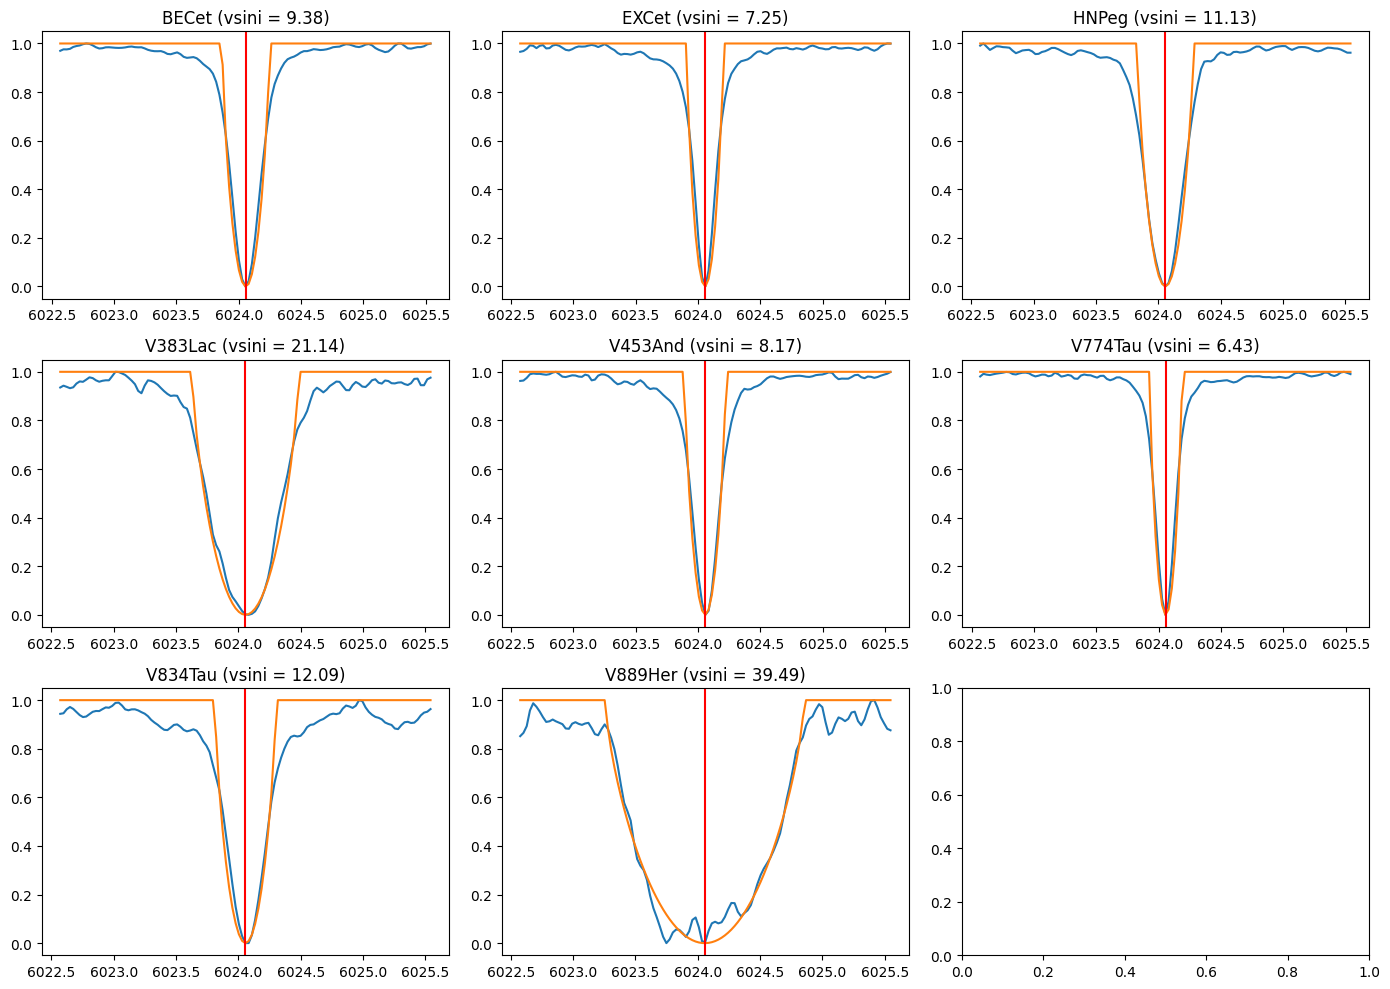

In [5]:
vsini_estimates = {}
fig, axes = plt.subplots(3, 3, figsize=(14, 10))
axes = axes.flatten()

for (target, data), ax in zip(features.items(), axes):
    vsini = estimate_vsini(data, _ABSORPTION_LINE)
    vsini_estimates[target] = vsini
    
    print(f"{target} vsini: {vsini}")
    y = minmax_scale(data[:, 1])
    g = _rotational_profile(data[:, 0], x0=_ABSORPTION_LINE, vsini=vsini)
    g_minmax = minmax_scale(g)
    
    ax.plot(data[:, 0], y, label="spectrum")
    ax.plot(data[:, 0], g_minmax, label="fit")
    ax.axvline(_ABSORPTION_LINE, color="red")
    ax.set(title=f"{target} (vsini = {vsini:.2f})")

plt.tight_layout()
plt.show()

# Comparison with literature values

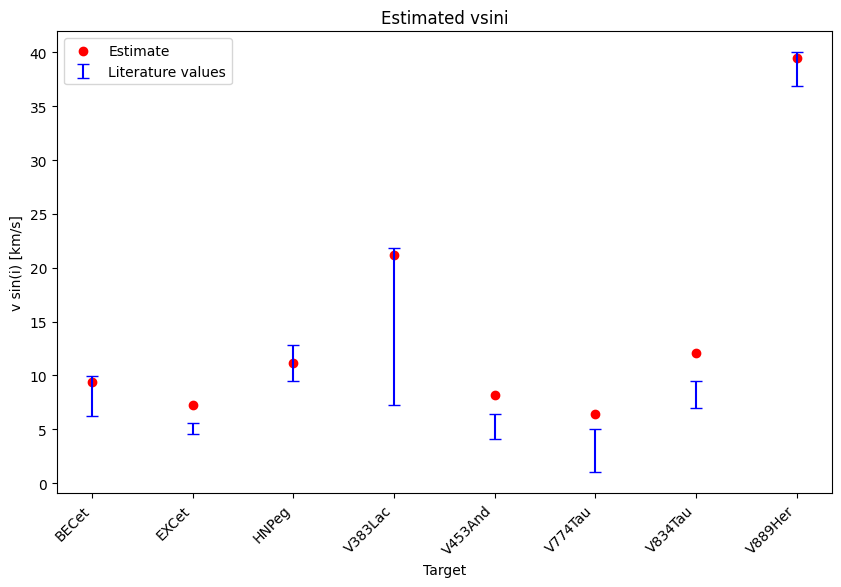

In [6]:
targets = list(vsini_estimates.keys())

x_values = np.arange(len(targets))
vsini_values = np.array(list(vsini_estimates.values()))
vsini_min_values = _star_data.loc[targets, "vsini_min"]
vsini_max_values = _star_data.loc[targets, "vsini_max"]
bar_lengths = (vsini_max_values - vsini_min_values) / 2
mid_points = (vsini_max_values + vsini_min_values) / 2

plt.figure(figsize=(10, 6))
plt.scatter(x_values, vsini_values, label='Estimate', color='red')

# Plotting theoretical min and max values
plt.errorbar(x_values, mid_points, yerr=[bar_lengths, bar_lengths],
             fmt='none', color='blue', capsize=4, label='Literature values')

plt.title('Estimated vsini')
plt.xlabel('Target')
plt.ylabel('v sin(i) [km/s]')
plt.xticks(x_values, targets, rotation=45, ha='right')
plt.legend()
plt.show()